In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from PIL import Image

In [2]:
data_train = pathlib.Path("data/train/")
test_dir = pathlib.Path("data/test/")
reals_dir = pathlib.Path(("data/people/"))

In [3]:
batch_size = 32
img_height = 100
img_width = 100
epochs = 3

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 14808 files belonging to 30 classes.
Using 11847 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 14808 files belonging to 30 classes.
Using 2961 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes {num_classes}")
print(class_names)

Number of classes 30
['Apple Golden', 'Apple Granny Smith', 'Apple Red', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cantaloupe', 'Cherry', 'Chestnut', 'Cocos', 'Eggplant', 'Guava', 'Hazelnut', 'Kiwi', 'Lemon', 'Mango', 'Onion Red', 'Orange', 'Papaya', 'Peach', 'Pear', 'Pepper Green', 'Potato Sweet', 'Potato White', 'Raspberry', 'Strawberry', 'Tomato', 'Walnut', 'Watermelon']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
resize_and_rescale = Sequential([
  layers.Resizing(100, 100),
  layers.Rescaling(1./255)
])

In [9]:
augment = Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ],
  name="augment"
)

In [10]:
model = Sequential([
  # resize_and_rescale,
  # augment,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# model.build(input_shape=(batch_size, img_height, img_width, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)       

In [13]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
371/371 [==============================] - 27s 66ms/step - loss: 0.3930 - accuracy: 0.8945 - val_loss: 0.0057 - val_accuracy: 0.9990
Epoch 2/3
371/371 [==============================] - 24s 64ms/step - loss: 0.0231 - accuracy: 0.9956 - val_loss: 0.0151 - val_accuracy: 0.9983
Epoch 3/3
371/371 [==============================] - 23s 63ms/step - loss: 0.0123 - accuracy: 0.9967 - val_loss: 3.4206e-04 - val_accuracy: 1.0000


In [14]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4959 files belonging to 30 classes.


In [15]:
model.evaluate(test_ds)

155/155 [==============================] - 3s 19ms/step - loss: 0.0992 - accuracy: 0.9776


[0.0991877019405365, 0.9776164293289185]

In [16]:
timestamp = int(datetime.datetime.now().timestamp())
model.save(f"models/fruit-origins-model-{timestamp}.h5")

In [17]:
model = tf.keras.models.load_model(f"models/fruit-origins-model-{timestamp}.h5")

In [18]:
# model = tf.keras.models.load_model(f"models/fruit-origins-model-1682942005.h5")
# model.layers.remove("augment")
# model.summery()

In [19]:
def predict(img):
    prediction = model.predict(img, verbose=False)
    score = tf.nn.softmax(prediction).numpy()[0]
    top_10_ind = np.argpartition(score, -10)[-10:]
    classes = np.array(class_names)
    top_10 = classes[top_10_ind]
    top_10_score = score[top_10_ind]
    result = [(cls, sc) for cls, sc in zip(top_10, top_10_score)]
    result.sort(key=lambda x: x[1], reverse=True)
    for cls, perc in result:
        if perc >= 0.0009:
            print(cls, f"{perc:.3%}")


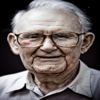

Onion Red 85.515%
Raspberry 14.472%


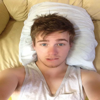

Cantaloupe 90.651%
Strawberry 8.083%
Hazelnut 0.376%
Onion Red 0.365%
Walnut 0.334%
Raspberry 0.119%


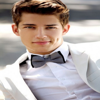

Eggplant 76.448%
Apple Red 21.493%
Watermelon 0.737%
Raspberry 0.682%
Walnut 0.317%
Onion Red 0.309%


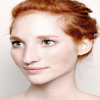

Cantaloupe 36.359%
Peach 26.618%
Kiwi 9.273%
Cocos 7.266%
Banana 5.719%
Apple Granny Smith 5.560%
Walnut 3.174%
Apple Red 2.949%
Hazelnut 1.502%
Potato Sweet 0.551%


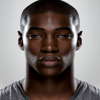

Strawberry 93.701%
Chestnut 6.268%


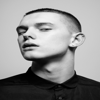

Watermelon 99.967%


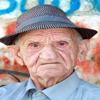

Cocos 77.445%
Chestnut 21.622%
Onion Red 0.281%
Raspberry 0.235%
Hazelnut 0.158%
Walnut 0.106%
Watermelon 0.099%


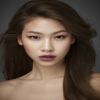

Cherry 60.713%
Eggplant 26.615%
Banana 7.201%
Strawberry 2.312%
Pepper Green 1.005%
Raspberry 0.800%
Onion Red 0.609%
Watermelon 0.436%
Apple Red 0.152%
Walnut 0.097%


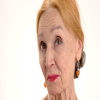

Cantaloupe 69.720%
Hazelnut 30.276%


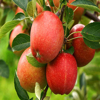

Strawberry 52.632%
Tomato 46.392%
Apricot 0.933%


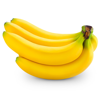

Banana 100.000%


In [23]:
for file in reals_dir.iterdir():
    img = Image.open(str(file))
    # img = tf.keras.utils.load_img(str(file))
    # print(img)
    # img_array = tf.keras.utils.img_to_array(img)
    # img_array = tf.expand_dims(img_array, 0) # Create a batch
    img = img.resize((img_width, img_height))
    display(img)
    img = tf.reshape(img, (-1, 100, 100, 3))
    predict(img)